# Exploratory Data Analysis

This notebook explores the e-commerce data related to selling performance collected after lighting offers for different products in a specific country for a given time period (2 months of data, June 2021 - July 2021).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  after removing the cwd from sys.path.


In [2]:
df_offers = pd.read_csv('/home/jupyter/ecommerce-analytics-examples/data/initial_data/ofertas_relampago.csv')

## 1. Initial exploration and column profiling

**Checking for possible data integrity issues: duplication, nulls and column types.**

In [3]:
df_offers.head(2)

OFFER_START_DATE           OFFER_START_DTTM          OFFER_FINISH_DTTM  \
0       2021-06-22  2021-06-22 16:00:00+00:00  2021-06-22 23:02:43+00:00   
1       2021-06-22  2021-06-22 13:00:00+00:00  2021-06-22 19:00:02+00:00   

       OFFER_TYPE  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  \
0  lightning_deal               4                         -2         4.72   
1  lightning_deal               5                          5          NaN   

   SOLD_QUANTITY ORIGIN SHIPPING_PAYMENT_TYPE DOM_DOMAIN_AGG1 VERTICAL  \
0            6.0      A                  none       PETS FOOD      CPG   
1            NaN    NaN         free_shipping    PET PRODUCTS   OTHERS   

                     DOMAIN_ID  
0               MLM-BIRD_FOODS  
1  MLM-ANIMAL_AND_PET_PRODUCTS

In [4]:
print(df_offers.shape, df_offers.drop_duplicates().shape, ' num duplicates: ', df_offers.shape[0]-df_offers.drop_duplicates().shape[0])

(48746, 13) (47820, 13)  num duplicates:  926


**Number of `NULL` values for each column**

In [5]:
df_offers.isna().sum()

OFFER_START_DATE                 0
OFFER_START_DTTM                 0
OFFER_FINISH_DTTM                0
OFFER_TYPE                       0
INVOLVED_STOCK                   0
REMAINING_STOCK_AFTER_END        0
SOLD_AMOUNT                  24167
SOLD_QUANTITY                24167
ORIGIN                       37430
SHIPPING_PAYMENT_TYPE            0
DOM_DOMAIN_AGG1                  0
VERTICAL                         0
DOMAIN_ID                        0
dtype: int64

Fixing data types for date columns

In [6]:
df_offers['OFFER_START_DATE'] = pd.to_datetime(df_offers['OFFER_START_DATE'])
df_offers['OFFER_START_DTTM'] = pd.to_datetime(df_offers['OFFER_START_DTTM'])
df_offers['OFFER_FINISH_DTTM'] = pd.to_datetime(df_offers['OFFER_FINISH_DTTM'])

In [7]:
df_offers.dtypes

OFFER_START_DATE                  datetime64[ns]
OFFER_START_DTTM             datetime64[ns, UTC]
OFFER_FINISH_DTTM            datetime64[ns, UTC]
OFFER_TYPE                                object
INVOLVED_STOCK                             int64
REMAINING_STOCK_AFTER_END                  int64
SOLD_AMOUNT                              float64
SOLD_QUANTITY                            float64
ORIGIN                                    object
SHIPPING_PAYMENT_TYPE                     object
DOM_DOMAIN_AGG1                           object
VERTICAL                                  object
DOMAIN_ID                                 object
dtype: object

## 2. Profile distribution for each column

In [8]:
profile_data = ProfileReport(df_offers)

In [9]:
profile_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Impute missing values

**It is assumed that `SOLD_QUANTITY` is `NULL` when no items were sold, thus this column will be imputed with 0. As for `ORIGIN`, it is either `A` or `NULL`, so it will be imputed with an `UNKNOWN` placeholder string. Column `SOLD_AMOUNT` will be imputed in a following section.**

In [10]:
df_offers['SOLD_QUANTITY'] = df_offers['SOLD_QUANTITY'].fillna(0)
df_offers['ORIGIN'] = df_offers['ORIGIN'].fillna('UNKNOWN')

## 4. Regarding Duplicates

In [11]:
df_duplicated = df_offers[df_offers.duplicated(keep=False)].sort_values(list(df_offers.columns))

In [12]:
df_duplicated.head(5)

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
39626       2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 13:00:02+00:00   
39640       2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 13:00:02+00:00   
39629       2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 13:00:08+00:00   
39630       2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 13:00:08+00:00   
40007       2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 13:00:08+00:00   

           OFFER_TYPE  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  \
39626  lightning_deal               5                          3        47.14   
39640  lightning_deal               5                          3        47.14   
39629  lightning_deal               5                          4          NaN   
39630  lightning_deal               5                          4          NaN   
40007  lightning_deal              15                         15          NaN   

       SOLD_QUANTITY   ORIGIN SHIPPING_PAYMENT_TYPE     DOM_DOMAIN_AGG1  \
39626            1.0  UNKNOWN         free_shipping           COMPUTERS   
39640            1.0  UNKNOWN         free_shipping           COMPUTERS   
39629            0.0  UNKNOWN         free_shipping           COMPUTERS   
39630            0.0  UNKNOWN         free_shipping           COMPUTERS   
40007            0.0  UNKNOWN         free_shipping  APPAREL ACCESORIES   

           VERTICAL       DOMAIN_ID  
39626            CE  MLM-HEADPHONES  
39640            CE  MLM-HEADPHONES  
39629            CE  MLM-HEADPHONES  
39630            CE  MLM-HEADPHONES  
40007  APP & SPORTS  MLM-SUNGLASSES

**There is no clear reason as to why there would be duplicated rows, other than either having missing identifying fields or errors during the data collection, so for the following analysis, **duplicated rows are removed**.**

In [13]:
df_offers = df_offers.drop_duplicates()

## 5. Interpretation of columns

### 5.1. REMAINING_STOCK_AFTER_END 

**If `REMAINING_STOCK_AFTER_END` is built as the difference between `INVOLVED_STOCK` and `SOLD_QUANTITY`, then the next sum is 0**

In [14]:
(df_offers['REMAINING_STOCK_AFTER_END'] -(df_offers['INVOLVED_STOCK']-df_offers['SOLD_QUANTITY'])).sum()

50860.0

**But it isn't, compute a `DEVIATIONS_FINAL_STOCK` and analyze the strange data**

In [15]:
df_offers['REMAINING_AS_DIFF'] = df_offers['INVOLVED_STOCK']-df_offers['SOLD_QUANTITY']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_offers['DEVIATIONS_FINAL_STOCK'] = np.abs(df_offers['REMAINING_AS_DIFF']-df_offers['REMAINING_STOCK_AFTER_END'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


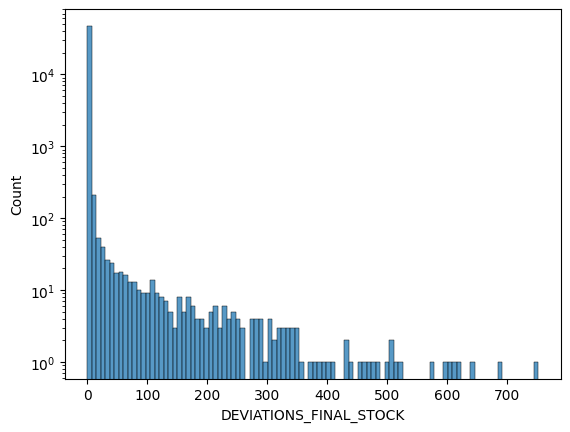

In [17]:
sns.histplot(df_offers, x='DEVIATIONS_FINAL_STOCK', bins=100)
plt.yscale('log')

In [18]:
num_deviated_diffs = 100*(df_offers['DEVIATIONS_FINAL_STOCK']>0).sum()/df_offers.shape[0]

print('The {:.3}% of the rows have a counter-intuitive behavior for REMAINING_STOCK_AFTER_END'.format(num_deviated_diffs))

The 7.34% of the rows have a counter-intuitive behavior for REMAINING_STOCK_AFTER_END


In [19]:
df_offers[df_offers['REMAINING_STOCK_AFTER_END']<0].shape

(1263, 15)

In [20]:
df_offers[df_offers['REMAINING_STOCK_AFTER_END']>=0].shape

(46557, 15)

In [64]:
df_remain = df_offers.groupby('REMAINING_STOCK_AFTER_END')['DOMAIN_ID'].count().reset_index()

(-100.0, 100.0)

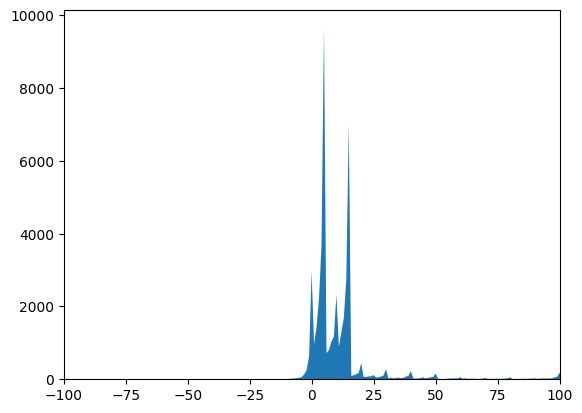

In [67]:
plt.stackplot(df_remain.REMAINING_STOCK_AFTER_END, df_remain.DOMAIN_ID)
plt.xlim([-100,100])

In [72]:
print( 'There are ', df_offers[df_offers['REMAINING_AS_DIFF']<0].shape[0], ' offers that end up selling more units than initially advertised,',
      'this might be related to a problem in data collection or the application itself, further business insight or alert required')

There are  1239  offers that end up selling more units than initially advertised, this might be related to a problem in data collection or the application itself, further business insight or alert required


## 5.2. SOLD_AMOUNT

**Supposed to be the price at which the item has been sold, there are some missing values but does not make sense to impute with 0, therefore, this column is imputed by taking the median of `SOLD_AMOUNT` for any given tuple of `DOM_DOMAIN_AGG1` and `VERTICAL`, which describe the product category/grouping.**

In [21]:
df_offers.sort_values('SOLD_AMOUNT', ascending=False).head(5)

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
11449       2021-07-27 2021-07-27 09:00:00+00:00 2021-07-27 17:01:05+00:00   
37095       2021-06-18 2021-06-18 15:00:00+00:00 2021-06-18 23:00:00+00:00   
13737       2021-07-19 2021-07-19 13:00:00+00:00 2021-07-19 21:00:55+00:00   
45804       2021-07-26 2021-07-26 17:00:00+00:00 2021-07-27 01:00:05+00:00   
13742       2021-07-19 2021-07-19 12:00:00+00:00 2021-07-19 20:00:00+00:00   

           OFFER_TYPE  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  \
11449  lightning_deal            2000                        497      4836.57   
37095  lightning_deal             100                         45      4678.68   
13737  lightning_deal            4000                       2358      4570.31   
45804  lightning_deal            2000                       1931      4264.51   
13742  lightning_deal            7000                       5650      3988.84   

       SOLD_QUANTITY ORIGIN SHIPPING_PAYMENT_TYPE   DOM_DOMAIN_AGG1  \
11449         1503.0      A                  none  BEAUTY EQUIPMENT   
37095           75.0      A         free_shipping            MOBILE   
13737         1646.0      A                  none     PHARMACEUTICS   
45804           67.0      A         free_shipping            MOBILE   
13742         1358.0      A                  none     PHARMACEUTICS   

              VERTICAL                          DOMAIN_ID  REMAINING_AS_DIFF  \
11449  BEAUTY & HEALTH              MLM-DISPOSABLE_GLOVES              497.0   
37095               CE                     MLM-CELLPHONES               25.0   
13737  BEAUTY & HEALTH  MLM-SURGICAL_AND_INDUSTRIAL_MASKS             2354.0   
45804               CE                     MLM-CELLPHONES             1933.0   
13742  BEAUTY & HEALTH  MLM-SURGICAL_AND_INDUSTRIAL_MASKS             5642.0   

       DEVIATIONS_FINAL_STOCK  
11449                     0.0  
37095                    20.0  
13737                     4.0  
45804                     2.0  
13742                     8.0

**Explore wethere it is possible to get a non-null value for the average of the price over each product category.**

In [22]:
df_offers.groupby(['DOMAIN_ID', 'DOM_DOMAIN_AGG1', 'VERTICAL'])['SOLD_AMOUNT'].agg(['mean', 'nunique', 'count']).reset_index().isna().sum()

DOMAIN_ID            0
DOM_DOMAIN_AGG1      0
VERTICAL             0
mean               359
nunique              0
count                0
dtype: int64

In [23]:
df_offers.groupby(['DOM_DOMAIN_AGG1', 'VERTICAL'])['SOLD_AMOUNT'].agg(['mean', 'nunique', 'count']).reset_index().isna().sum()

DOM_DOMAIN_AGG1    0
VERTICAL           0
mean               1
nunique            0
count              0
dtype: int64

In [24]:
df_price_by_cat = df_offers.groupby(['DOM_DOMAIN_AGG1', 'VERTICAL'])['SOLD_AMOUNT'].agg(['median', 'mean', 'std', 'min', 'max', 'nunique', 'count', 'size'])
df_price_by_cat['nan_count'] = df_price_by_cat['size'] - df_price_by_cat['count']
df_price_by_cat = df_price_by_cat.sort_values('nan_count', ascending=False).reset_index()
df_price_by_cat['skewness'] = 3*(df_price_by_cat['mean']-df_price_by_cat['median'])/(df_price_by_cat['std'])
df_price_by_cat['missing_percentage'] = 100*df_price_by_cat['nan_count']/df_price_by_cat['size'] 

In [25]:
df_price_by_cat.round(2).style.bar(subset=['median', 'mean', 'std', 'min', 'max', 'nunique', 'count', 'size', 'nan_count', 'missing_percentage', 'skewness'], color='#1ACE5C')\
                        .format({col_key : '{:.2f}' for col_key in ['median', 'mean', 'std', 'min', 'max', 'missing_percentage', 'skewness']})

In [26]:
print('The top 5 product categories that contain the most NULL values are:', ', '.join(df_price_by_cat['DOM_DOMAIN_AGG1'][:5].tolist()), '\n',
      'While the categories that have the highest percentage of NULLs are: ',
      ', '.join(df_price_by_cat.sort_values('missing_percentage', ascending=False)['DOM_DOMAIN_AGG1'][:5].tolist()))

The top 5 product categories that contain the most NULL values are: HOME&DECOR, APPAREL ACCESORIES, APPAREL, SPORTS, ELECTRONICS 
 While the categories that have the highest percentage of NULLs are:  AGRO, BABY, MUSICAL INSTRUMENTS, WHEELS & TIRES, TOYS AND GAMES


**The median is chosen as the impute strategy instead of the mean, this is because all the distributions are positively skewed, as shown by the skewness values higher than +0.5 for all of them, so the median makes it more robust against the outliers. The category AGRO doesn't have a single value and it's just 1 register, so it will be removed from further analysis.**

In [27]:
df_offers = df_offers[df_offers['DOM_DOMAIN_AGG1']!='AGRO']

In [28]:
df_med_price = df_offers.groupby(['DOM_DOMAIN_AGG1', 'VERTICAL'])['SOLD_AMOUNT'].median().reset_index()
df_med_price = df_med_price.rename(columns={'SOLD_AMOUNT' : 'SOLD_AMOUNT_IMPUTE'})

In [29]:
df_offers = df_offers.merge(df_med_price, how='left')

In [30]:
df_offers.at[df_offers['SOLD_AMOUNT'].isna(), 'SOLD_AMOUNT'] = df_offers[df_offers['SOLD_AMOUNT'].isna()]['SOLD_AMOUNT_IMPUTE']
df_offers = df_offers.drop(columns=['SOLD_AMOUNT_IMPUTE'])

In [31]:
df_offers.SOLD_AMOUNT.isna().sum()

0

## 5.3. OFFER_DURATION

Compute how long did the offer last as `OFFER_DURATION` measured in seconds

In [32]:
df_offers['OFFER_DURATION'] = (df_offers['OFFER_FINISH_DTTM']-df_offers['OFFER_START_DTTM']).astype('timedelta64[s]')

In [33]:
df_offers['OFFER_DURATION'].describe()

count     47819.000000
mean      20528.241515
std        7571.271445
min           0.000000
25%       21600.000000
50%       21602.000000
75%       21610.000000
max      377109.000000
Name: OFFER_DURATION, dtype: float64

In [34]:
df_offers['OFFER_DURATION'].describe()/3600

count     13.283056
mean       5.702289
std        2.103131
min        0.000000
25%        6.000000
50%        6.000556
75%        6.002778
max      104.752500
Name: OFFER_DURATION, dtype: float64

**There seem to be outliers, check how many**

In [35]:
print( 'There are ', (df_offers['OFFER_DURATION'] > 3600*6).sum(), ' lighting offers that lasted more than 6 hours, ',
      (df_offers['OFFER_DURATION'] > 3600*12).sum(), ' that lasted more than 12 hours, and ',
    (df_offers['OFFER_DURATION'] > 3600*24).sum(), ' that lasted more than 24 hours')

There are  33968  lighting offers that lasted more than 6 hours,  175  that lasted more than 12 hours, and  1  that lasted more than 24 hours


**Since there is only one outlier with more than 24 hours, it will be removed from further analysis.**

In [36]:
df_offers = df_offers[df_offers['OFFER_DURATION']<=3600*24]

<AxesSubplot:xlabel='OFFER_DURATION'>

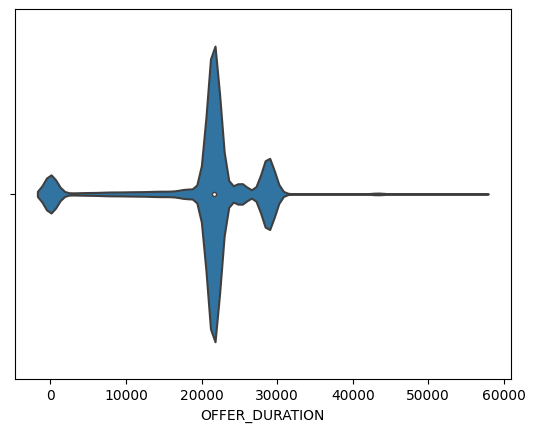

In [37]:
sns.violinplot(df_offers, x='OFFER_DURATION')
#plt.xlim([0,50000])

<AxesSubplot:xlabel='OFFER_DURATION', ylabel='Density'>

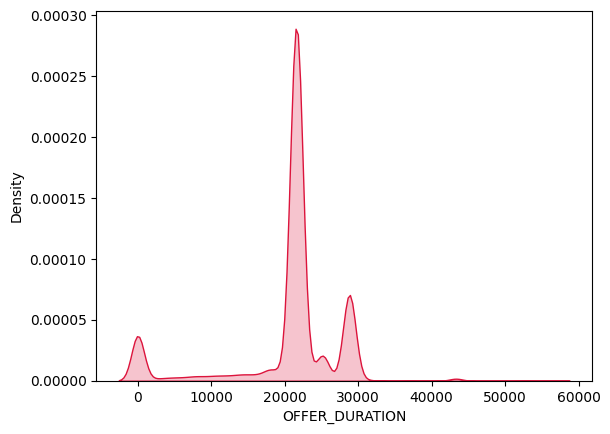

In [38]:
sns.kdeplot(df_offers, x='OFFER_DURATION', color='crimson', fill=1 )

**Peaks in the distribution show that there are common intervals chosen for lighting offers they can be easier to see in terms of hours**

<AxesSubplot:xlabel='OFFER_DURATION', ylabel='Count'>

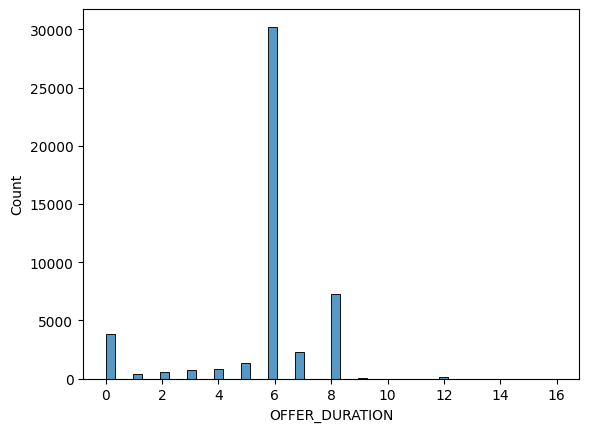

In [39]:
sns.histplot(np.round(df_offers['OFFER_DURATION']/3600), bins=50)

In [40]:
print('Commonly, light offers last', np.round(df_offers['OFFER_DURATION']/3600).value_counts().reset_index()['index'][:3].tolist(), 'hours')

Commonly, light offers last [6.0, 8.0, 0.0] hours


## 5.4. Relationship between time and price

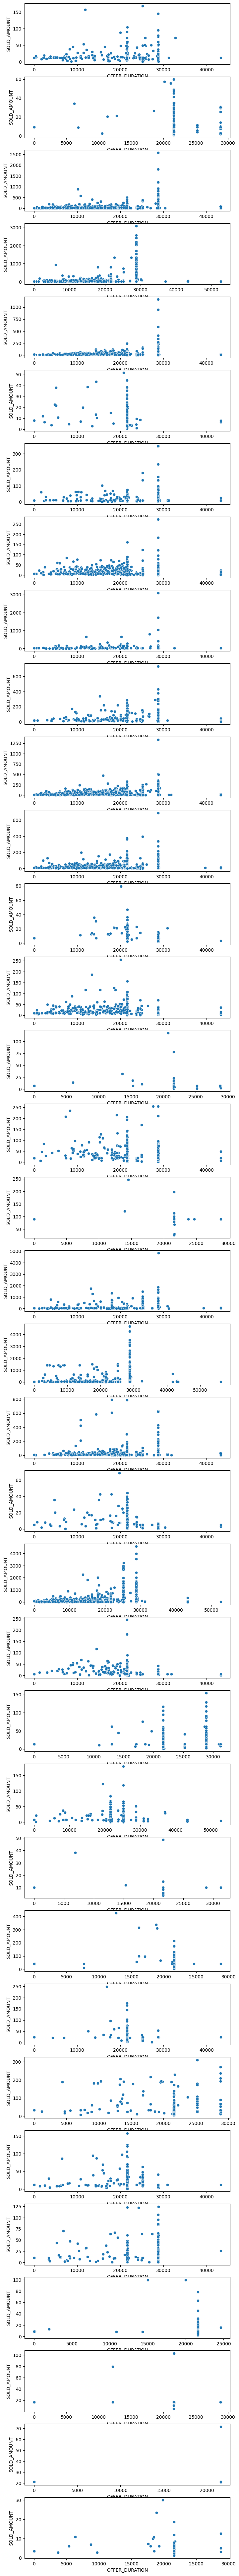

In [41]:
fig, ax = plt.subplots(figsize=(8,100), nrows=len(df_offers['DOM_DOMAIN_AGG1'].unique()), ncols=1)
for i_plot, product_cat in enumerate(df_offers['DOM_DOMAIN_AGG1'].unique()):
    sns.scatterplot(data=df_offers[df_offers['DOM_DOMAIN_AGG1']==product_cat],
                x="OFFER_DURATION", y="SOLD_AMOUNT", ax=ax[i_plot])

In [42]:
print('Pearson Correlation between SOLD_AMOUNT and OFFER_DURATION:\n')
for i_plot, product_cat in enumerate(df_offers['DOM_DOMAIN_AGG1'].unique()):
    df_cat = df_offers[df_offers['DOM_DOMAIN_AGG1']==product_cat]
    cor_val, p_val = pearsonr( df_cat['SOLD_AMOUNT'], df_cat['OFFER_DURATION'])
    if p_val < 0.05:
        print( product_cat, ': ', cor_val, ' - p_val: ', p_val )

Pearson Correlation between SOLD_AMOUNT and OFFER_DURATION:

COMPUTERS :  0.08124492196840097  - p_val:  8.554118739892273e-07
ELECTRONICS :  0.13250051762914195  - p_val:  6.429635331851368e-13
APPAREL :  0.05122645437315578  - p_val:  0.0015526257680462952
TOOLS AND CONSTRUCTION :  0.06825381542663476  - p_val:  0.009158044870244023
BEAUTY EQUIPMENT :  0.12021241831016595  - p_val:  6.718980075754316e-05
MOBILE :  0.1467502809174165  - p_val:  4.4254308862607597e-10
PHARMACEUTICS :  0.2214722601015429  - p_val:  8.315790420220071e-35
CLEANING :  0.11072541218807494  - p_val:  0.036776141790933574


**Specially for products in PHARMACEUTICS, MOBILE, BEAUTY EQUIPMENT and CLEANING, some small positive correlation is found, meaning that products with higher price usually have longer time-limits**

## 5.5. Offers in time

In [43]:
df_count_by_cat = df_offers.groupby(['OFFER_START_DATE', 'VERTICAL'])['DOMAIN_ID'].count().reset_index()
norm_by_cat = df_count_by_cat.groupby('OFFER_START_DATE')['DOMAIN_ID'].sum().reset_index()
norm_by_cat = norm_by_cat.rename(columns={'DOMAIN_ID':'DAILY_NORM'})
df_count_by_cat = df_count_by_cat.merge( norm_by_cat, how='left' )
df_count_by_cat['NORM_DOMAIN_ID'] = df_count_by_cat['DOMAIN_ID']/df_count_by_cat['DAILY_NORM']

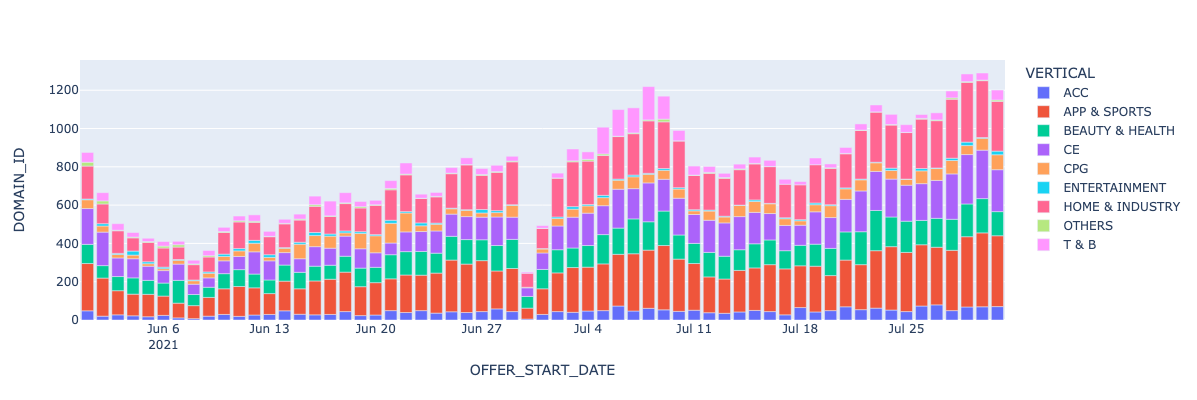

In [44]:
fig = px.bar(df_count_by_cat, x='OFFER_START_DATE', y='DOMAIN_ID',color='VERTICAL',
             labels={'pop':'Number of lighting offers'}, height=400)
fig.show()

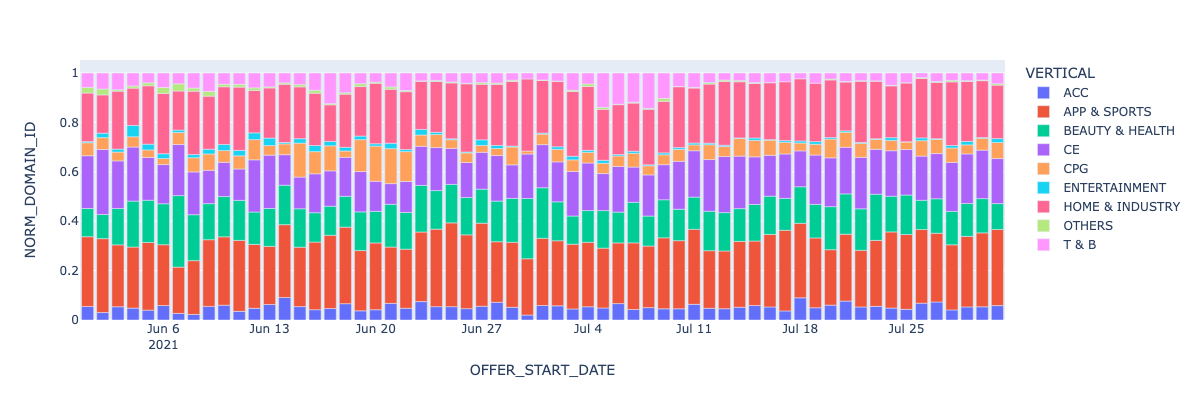

In [45]:
fig = px.bar(df_count_by_cat, x='OFFER_START_DATE', y='NORM_DOMAIN_ID',color='VERTICAL',
             labels={'pop':'Number of lighting offers'}, height=400)
fig.show()

**Small increasing trend observed in ligthing offers in time, as well as unusually low records for june 30th and july 1st. Proportionally there is not a marked trend for any specific market vertical.**

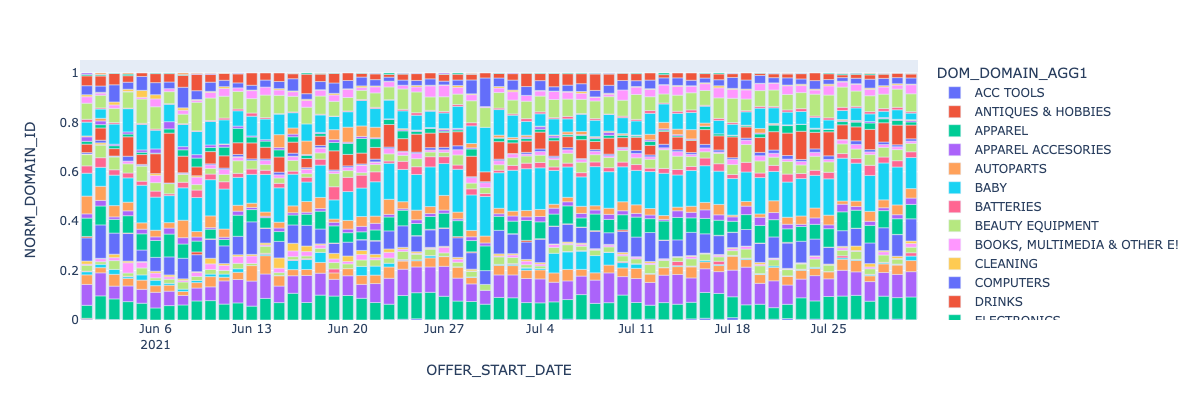

In [46]:
df_count_by_cat = df_offers.groupby(['OFFER_START_DATE', 'DOM_DOMAIN_AGG1'])['DOMAIN_ID'].count().reset_index()
norm_by_cat = df_count_by_cat.groupby('OFFER_START_DATE')['DOMAIN_ID'].sum().reset_index()
norm_by_cat = norm_by_cat.rename(columns={'DOMAIN_ID':'DAILY_NORM'})
df_count_by_cat = df_count_by_cat.merge( norm_by_cat, how='left' )
df_count_by_cat['NORM_DOMAIN_ID'] = df_count_by_cat['DOMAIN_ID']/df_count_by_cat['DAILY_NORM']

fig = px.bar(df_count_by_cat, x='OFFER_START_DATE', y='NORM_DOMAIN_ID',color='DOM_DOMAIN_AGG1',
             labels={'pop':'Number of lighting offers'}, height=400)
fig.show()

## 5.6. Sales by category

In [47]:
df_quantities = df_offers.groupby(['DOM_DOMAIN_AGG1'])[['SOLD_QUANTITY','INVOLVED_STOCK', 'SOLD_AMOUNT']].sum().reset_index()

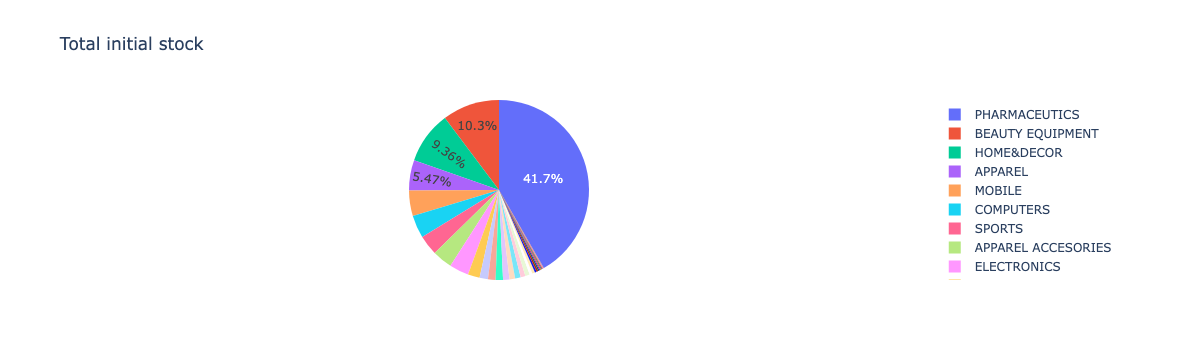

In [48]:
fig = px.pie(df_quantities, values='INVOLVED_STOCK', names='DOM_DOMAIN_AGG1', title='Total initial stock')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

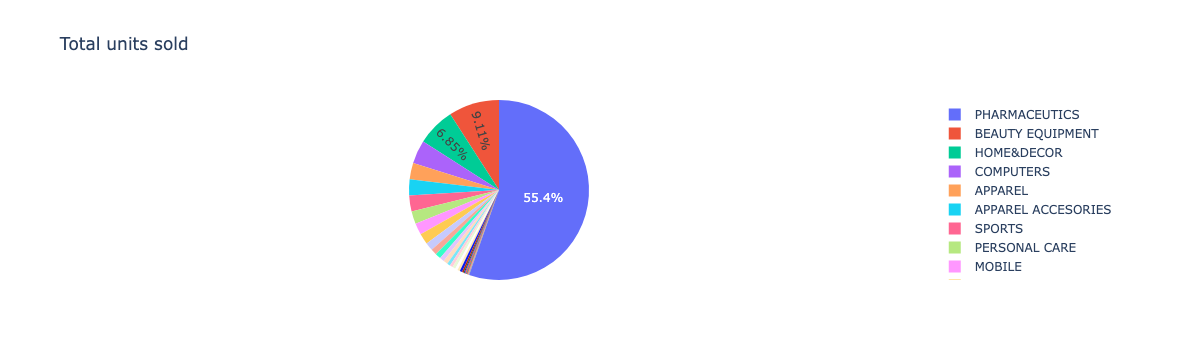

In [49]:
fig = px.pie(df_quantities, values='SOLD_QUANTITY', names='DOM_DOMAIN_AGG1', title='Total units sold')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

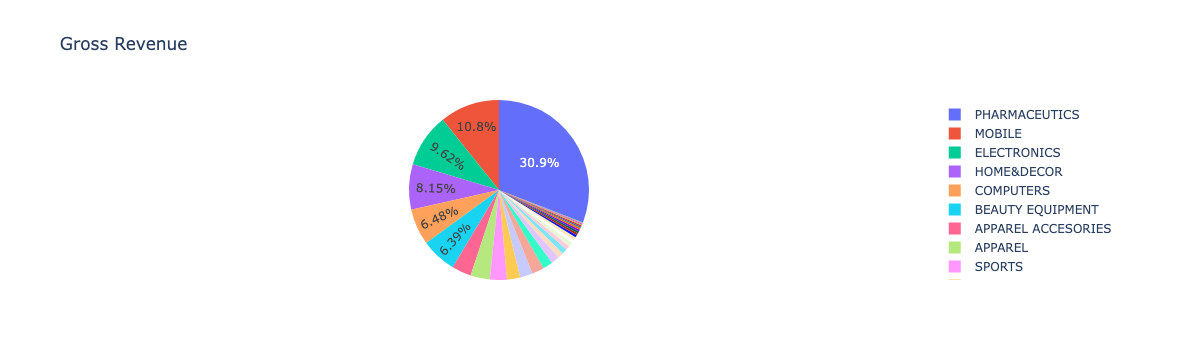

In [50]:
fig = px.pie(df_quantities, values='SOLD_AMOUNT', names='DOM_DOMAIN_AGG1', title='Gross Revenue')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

**`PHARMACEUTICS` is the domain with more products shown in lighting offers and subsequently sold, while also having the highest revenue.**

In [51]:
df_offers['DOMAIN_ID'].nunique()

1265

In [58]:
df_sales_products = df_offers.groupby('DOMAIN_ID')[['SOLD_AMOUNT', 'INVOLVED_STOCK', 'SOLD_QUANTITY']].sum().reset_index()
df_sales_products['NORM_SOLD_AMOUNT'] = df_sales_products['SOLD_AMOUNT']/df_sales_products['SOLD_AMOUNT'].sum()
df_sales_products['NORM_SOLD_QUANTITY'] = df_sales_products['SOLD_QUANTITY']/df_sales_products['SOLD_QUANTITY'].sum()
df_sales_products['NORM_INVOLVED_STOCK'] = df_sales_products['INVOLVED_STOCK']/df_sales_products['INVOLVED_STOCK'].sum()
df_sales_products = df_sales_products.sort_values('SOLD_AMOUNT', ascending=False).reset_index().drop(columns=['index'])
df_sales_products['CUMULATIVE_SOLD_AMOUNT'] = df_sales_products['NORM_SOLD_AMOUNT'].cumsum()
df_sales_products[df_sales_products['CUMULATIVE_SOLD_AMOUNT']<=0.8].style.bar(subset=['NORM_SOLD_AMOUNT', 'NORM_SOLD_QUANTITY', 'NORM_INVOLVED_STOCK'], color='#1ACE5C')

**There are 1265 unique products, out of which, 106 concentrate the 80% of the revenue. Interestingly, `SURGICAL_AND_INDUSTRIAL_MASKS` is by far the top offered and selling product, and the reason for `PHARMACEUTICS` to be the top category, which is clearly related to the COVID-19 pandemic, since these offers were created between june and july 2021.**

## 5.7 Which domains offer free shipping?

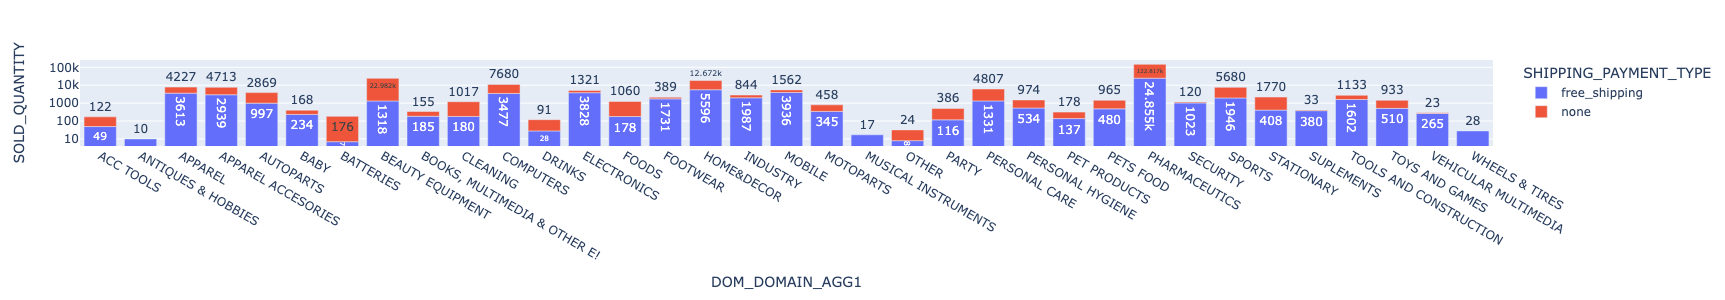

In [120]:
df_shipping = df_offers.groupby(['DOM_DOMAIN_AGG1', 'SHIPPING_PAYMENT_TYPE'])['SOLD_QUANTITY'].sum().reset_index()
fig = px.bar(df_shipping, x='DOM_DOMAIN_AGG1', y='SOLD_QUANTITY',color='SHIPPING_PAYMENT_TYPE', height=300, text_auto=True, log_y=True)
fig.show()

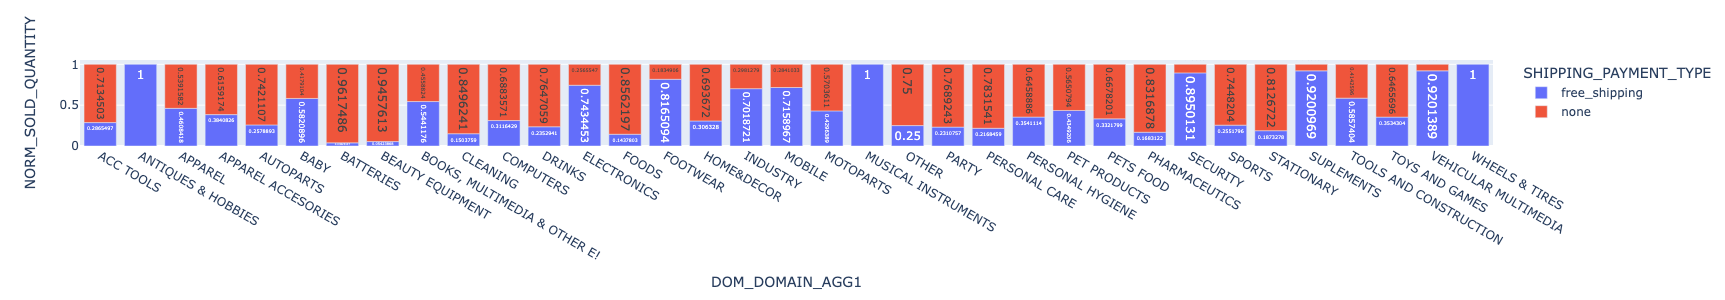

In [121]:

df_ship_norm = df_shipping.groupby('DOM_DOMAIN_AGG1')['SOLD_QUANTITY'].sum().reset_index()
df_ship_norm = df_ship_norm.rename(columns={'SOLD_QUANTITY':'SUM_SOLD_QUANTITY'})
df_shipping = df_shipping.merge(df_ship_norm, how='left')
df_shipping['NORM_SOLD_QUANTITY'] = df_shipping['SOLD_QUANTITY']/df_shipping['SUM_SOLD_QUANTITY']

fig = px.bar(df_shipping, x='DOM_DOMAIN_AGG1', y='NORM_SOLD_QUANTITY',color='SHIPPING_PAYMENT_TYPE', height=300, text_auto=True)
fig.show()

**For 'WHEELS & TIRES', 'ANTIQUES & HOBBIES', 'MUSICAL INSTRUMENTS', 'VEHICULAR MULTIMEDIA', 'SUPLEMENTS' and 'SECURITY' categories, it is observed that they almost always provide free shipping their lighting offers, however the first 4 of those are also categories with a small number of listings and sales so are not very significant. 'FOOTWEAR', 'ELECTRONICS', 'INDUSTRY' and 'MOBILE' are also commonly offered through free shipping and their sales numbers are more relevant than the previously mentioned, being categories with more popular products. As for PHARMACEUTICS it is interesting that it does not provide free shipping often, actually falling way below the average, yet as mentioned early it contains the largest amount of sales. Similarly goes for another predominant category: 'BEAUTY EQUIPMENT'**

## 5.8. Does free shipping actually impact sales?

First compute an efficiency of the offer (percentage of how many items were sold out of those initially in stock) then compare its average with and without free shipping.

In [122]:
df_offers['EFFICIENCY_OFFER'] = 100*df_offers['SOLD_QUANTITY']/df_offers['INVOLVED_STOCK']

In [132]:
df_efficiency_stats = df_offers.groupby(['DOM_DOMAIN_AGG1', 'SHIPPING_PAYMENT_TYPE'])['EFFICIENCY_OFFER'].describe().reset_index()

In [133]:
df_efficiency_stats

DOM_DOMAIN_AGG1 SHIPPING_PAYMENT_TYPE   count       mean        std  \
0              ACC TOOLS         free_shipping    49.0  15.238095  25.349410   
1              ACC TOOLS                  none    46.0  29.347826  34.509756   
2     ANTIQUES & HOBBIES         free_shipping     5.0  26.666667  26.246693   
3                APPAREL         free_shipping  2360.0  14.728647  25.225863   
4                APPAREL                  none  1454.0  23.396580  36.981691   
..                   ...                   ...     ...        ...        ...   
62        TOYS AND GAMES         free_shipping   947.0   6.963613  18.591273   
63        TOYS AND GAMES                  none   428.0  26.146677  74.574278   
64  VEHICULAR MULTIMEDIA         free_shipping    92.0  27.893375  34.472588   
65  VEHICULAR MULTIMEDIA                  none    10.0  16.666667  21.829870   
66        WHEELS & TIRES         free_shipping    33.0  16.666667  31.291639   

    min  25%        50%        75%          max  
0   0.0  0.0   0.000000  20.000000   100.000000  
1   0.0  0.0  20.000000  40.000000   160.000000  
2   0.0  0.0  33.333333  40.000000    60.000000  
3   0.0  0.0   0.000000  20.000000   140.000000  
4   0.0  0.0   6.666667  33.333333   560.000000  
..  ...  ...        ...        ...          ...  
62  0.0  0.0   0.000000   5.857143   260.000000  
63  0.0  0.0   0.000000  26.666667  1300.000000  
64  0.0  0.0  17.142857  46.666667   120.000000  
65  0.0  0.0  10.000000  25.000000    66.666667  
66  0.0  0.0   0.000000  20.000000   100.000000  

[67 rows x 10 columns]

In [152]:
df_efficiency_global = df_offers.groupby(['DOM_DOMAIN_AGG1'])['EFFICIENCY_OFFER'].describe().reset_index()

(0.0, 100.0)

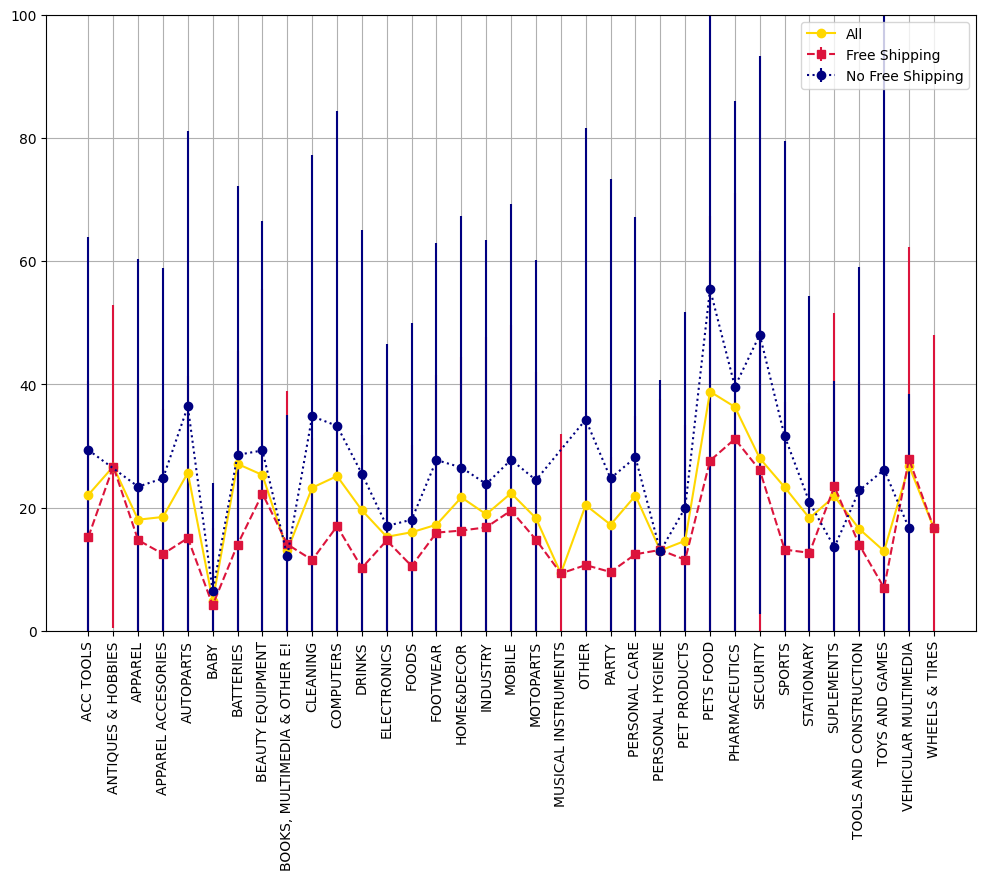

In [153]:
plt.figure(figsize=(12,8))
plt.errorbar( x=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']=='free_shipping']['DOM_DOMAIN_AGG1'],
              y=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']=='free_shipping']['mean'],
              yerr=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']=='free_shipping']['std'],
              color='crimson', marker='s', linestyle='--', label='Free Shipping'
            )
plt.errorbar( x=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']!='free_shipping']['DOM_DOMAIN_AGG1'],
              y=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']!='free_shipping']['mean'],
              yerr=df_efficiency_stats[df_efficiency_stats['SHIPPING_PAYMENT_TYPE']!='free_shipping']['std'],
              color='navy', marker='o', linestyle=':', label='No Free Shipping'
            )
plt.plot( df_efficiency_global['DOM_DOMAIN_AGG1'],
              df_efficiency_global['mean'],
              color='gold', marker='o', linestyle='-', label='All'
            )
plt.grid()
plt.legend(loc='best')
plt.xticks(rotation=90)[1][1]
plt.ylim([0,100])

**It seems that the efficiency score of the offer is not actually increased in average for any of the product categories when free shipping is included (actually the score is lower for most of the categories, which is counter-intuitive) with maybe the exception of SUPPLEMENTS and VEHICULAR MULTIMEDIA, nevertheless the standard deviation is so high that it is not possible to draw definitive conclussions, and more data would be required. This plot also reveals that usually lighting offers don't sell more than 60% of the planned stock, with the better performance found in PETS FOOD, SECURITY and PHARMACEUTICS.**

In [154]:
df_offers.to_csv('/home/jupyter/ecommerce-analytics-examples/data/preproc_data/ofertas_relampago_preproc.csv', index=False)